In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay

# TLDR

Even a "simple" logistic regression is susceptible to overfitting bias (what quants disparagingly call "data-mining"). This is why we adjust $R^2$ in OLS LM's.

# Thesis

In fact, the example below is so extreme as to make overfitting almost impossible: I literally include the ground-truth Bernoulli $\vec{\theta}$ as a regressor. Yet, we see overfitting (ROC up from $0.76$ to $0.88$).

In real life, the overfitting is compounded by two effects:
* Real-life $u$'s (unmodeled effects), shocks (regime shifts), and noise (just random animal spirits) is _much, much_ greater than below.
* RavenPack spams 100 different researchers with 100 different macro series they want to sell us, and the 99 researchers whose series yields null results silently ignore the email and get back to work, while the 1 researcher who got a positive result presents it to Ashwin in the M&Ms meeting.

There are only two solutions:
* Anchor to an economically-intuitive prior.
* Look for consistency across time periods, geographies, and asset classes.
* Find OOS data, even if that means a Partner who happens to also be a Prof at Yale has to pay a grad student to copy down handwritten wheat prices from a book he found in Beinecke (true anecdote).

# DATA

/var/folders/3d/0fl1m9tn35x29rk2094gf9sc0000gn/T/ipykernel_24898/1635405386.py:8: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "true_p"] = np.linspace(
/var/folders/3d/0fl1m9tn35x29rk2094gf9sc0000gn/T/ipykernel_24898/1635405386.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "logit_true_p"] = scipy.special.logit(
/var/folders/3d/0fl1m9tn35x29rk2094gf9sc0000gn/T/ipykernel_24898/1635405386.py:18: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new

<AxesSubplot: >

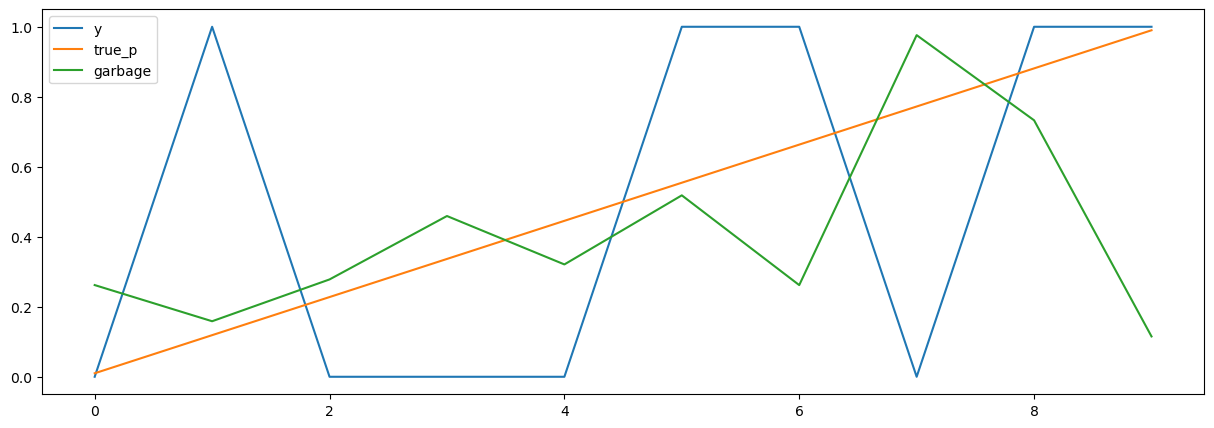

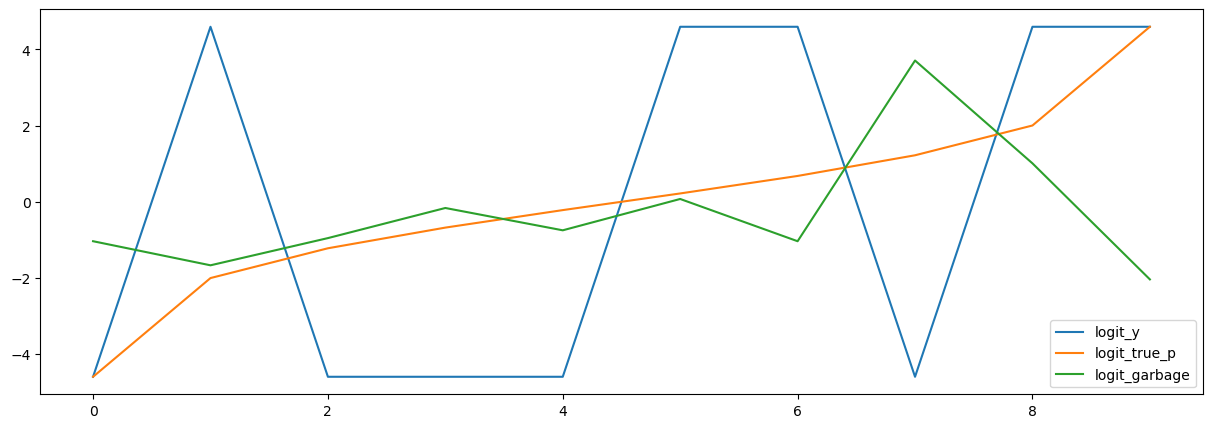

In [52]:
N = 10
df = pd.DataFrame(
    columns=["y", "logit_y", "true_p", "logit_true_p", "garbage", "logit_garbage"],
    index=range(N),
)

# ground-truth Pr[success] is just 0...1
df.loc[:, "true_p"] = np.linspace(
    start=0.01,
    stop=0.99,
    num=N,
)
df.loc[:, "logit_true_p"] = scipy.special.logit(
    df["true_p"]
)

# simulate independent Bernoulli flips according to those probabilities
df.loc[:, "y"] = stats.bernoulli.rvs(
    p=df["true_p"],
    size=N,
    random_state=42,
)
df.loc[:, "logit_y"] = scipy.special.logit(
    # have to fudge a bit
    df["y"] * 0.98 + 0.01
)

# random garbage
df.loc[:, "garbage"] = stats.uniform.rvs(
    size=N,
    random_state=1337,
)
df.loc[:, "logit_garbage"] = scipy.special.logit(
    df["garbage"]
)

df[["y", "true_p", "garbage"]].plot(
    figsize=(15, 5),
)
df[["logit_y", "logit_true_p", "logit_garbage"]].plot(
    figsize=(15, 5),
)

# MODELS

In [53]:
# ground-truth model
X0 = df[["logit_true_p"]]

m0 = LogisticRegression(penalty="none").fit(
    y=df["y"],
    X=X0,
)
preds0 = pd.DataFrame(
    m0.predict_proba(
        X=X0
    )
)[1]

In [54]:
# ground-truth model + a garbage feature
X1 = df[["logit_true_p", "logit_garbage"]]

m1 = LogisticRegression(penalty="none").fit(
    y=df["y"],
    X=X1,
)
preds1 = pd.DataFrame(
    m1.predict_proba(
        X=X1
    )
)[1]

# ANALYZE

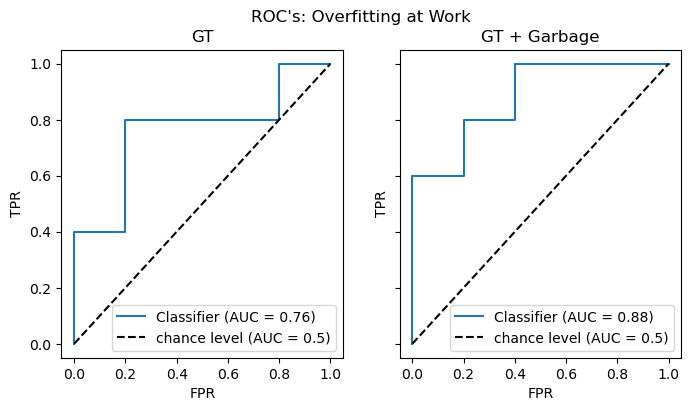

In [56]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

ax = axs[0]
RocCurveDisplay.from_predictions(
    y_true=df["y"],
    y_pred=preds0,
    ax=ax,
)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("GT")
ax.legend()

ax = axs[1]
RocCurveDisplay.from_predictions(
    y_true=df["y"],
    y_pred=preds1,
    ax=ax,
)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("GT + Garbage")
ax.legend()

plt.suptitle("ROC's: Overfitting at Work")
fig.set_size_inches(8, 4)
plt.show()